- https://github.com/vsitzmann/awesome-implicit-representations
- https://github.com/yudhisteer/Learning-3D-Vision-with-Inverse-Graphics---Part-I
- https://github.com/yudhisteer/Learning-3D-Vision-with-Inverse-Graphics---Part-II
- https://github.com/yudhisteer/Assessing-NeRF-s-Efficacy-in-3D-Model-Reconstruction-A-Comparative-Analysis-with-Blender

# Implicit Neural Representations - Neural Field (SIREN)

This is a jupyter notebook to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output, coords  

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [ ]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little dataset that does nothing except calculating per-pixel coordinates:

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

### SIREN

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [ ]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.327821


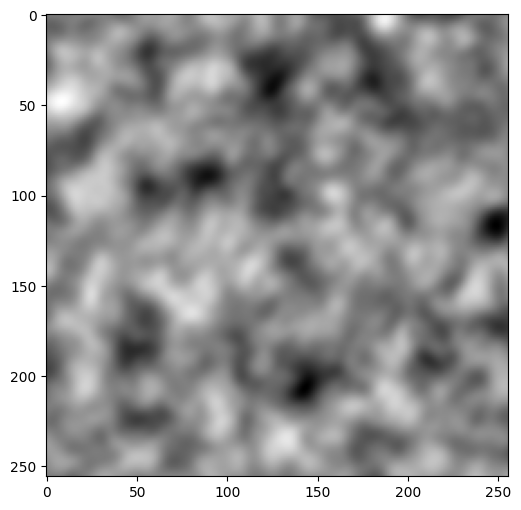

Step 50, Total loss 0.012276


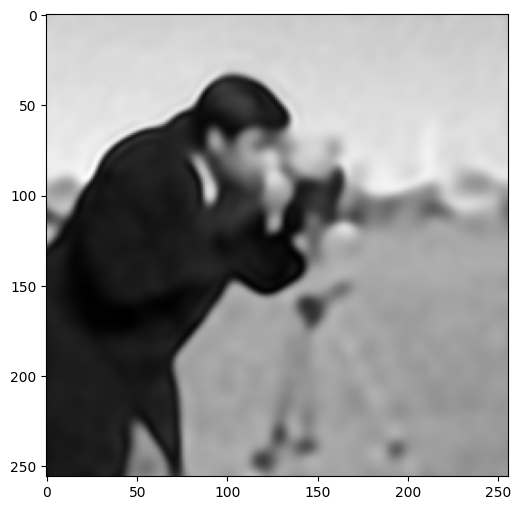

Step 100, Total loss 0.008364


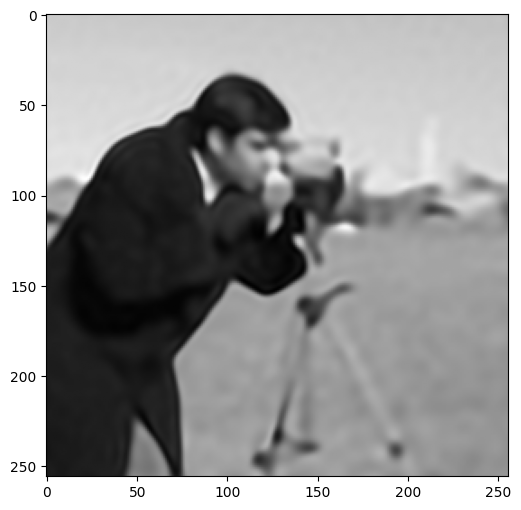

Step 150, Total loss 0.005986


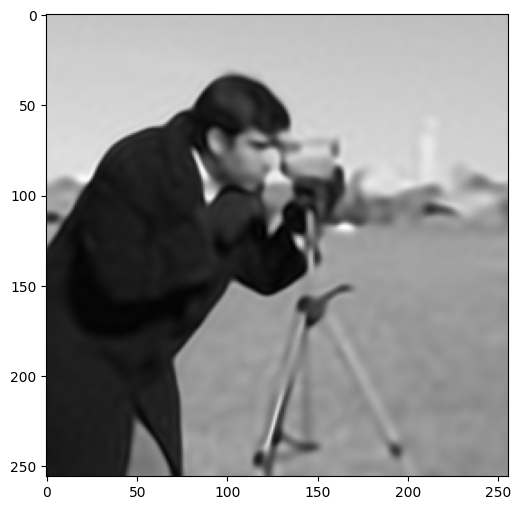

Step 200, Total loss 0.004235


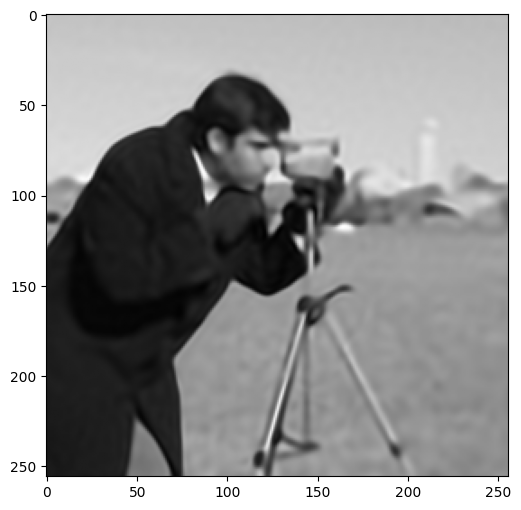

Step 250, Total loss 0.002788


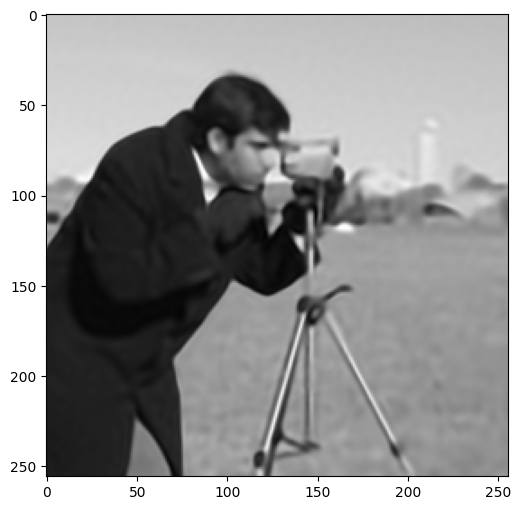

Step 300, Total loss 0.002036


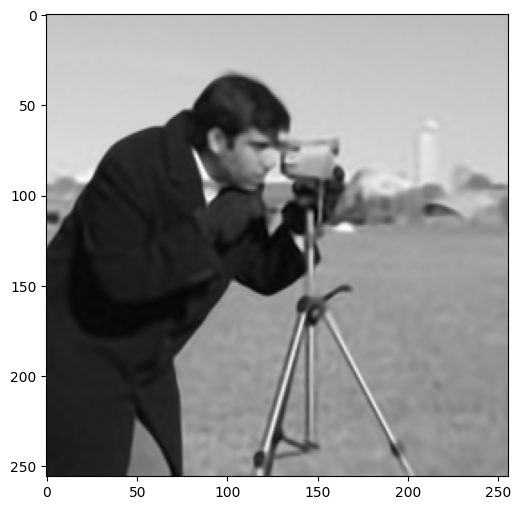

Step 350, Total loss 0.001620


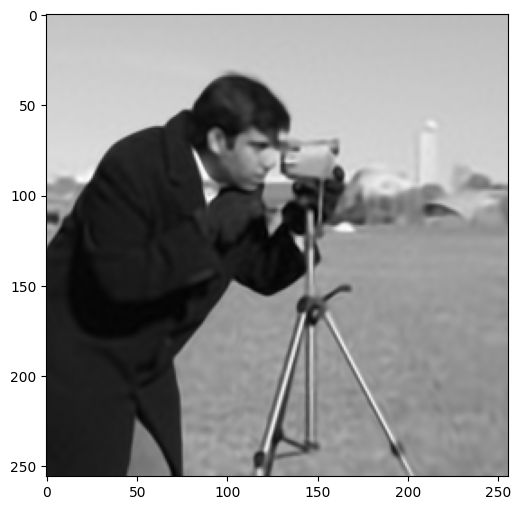

Step 400, Total loss 0.001314


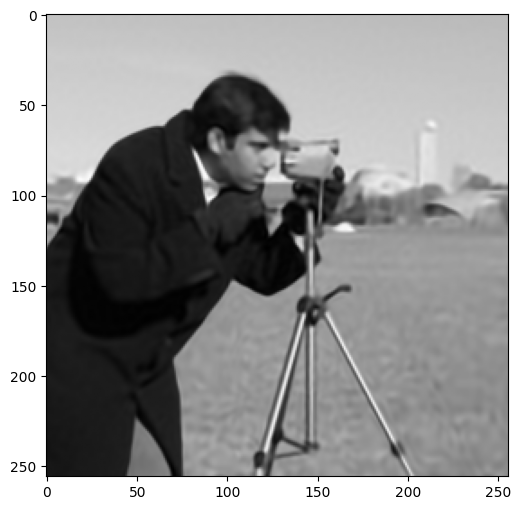

Step 450, Total loss 0.001116


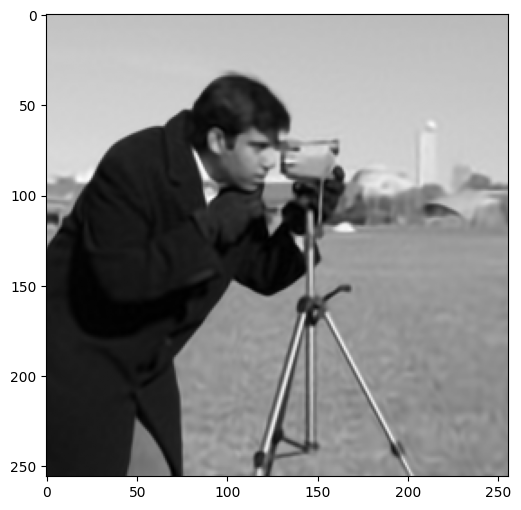

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, ax = plt.subplots(1,1, figsize=(6,6))
        ax.imshow(model_output.cpu().view(256,256).detach().numpy(), cmap='gray')
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

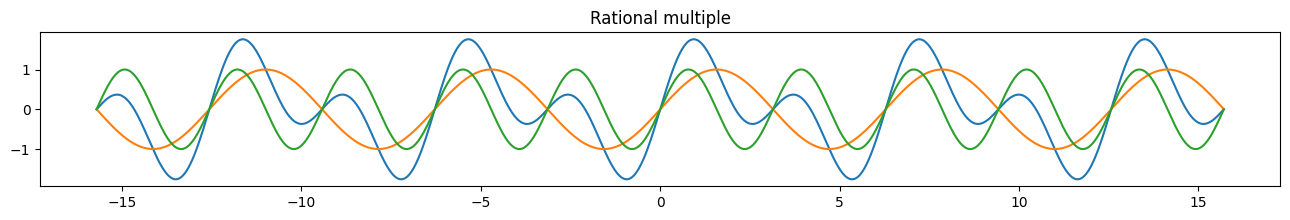

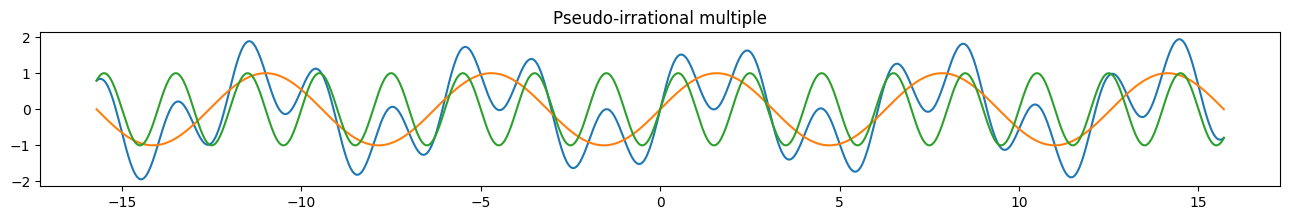

In [ ]:
with torch.no_grad():
    coords = get_mgrid(2**10, 1) * 5 * np.pi
    
    sin_1 = torch.sin(coords)
    sin_2 = torch.sin(coords * 2)
    sum = sin_1 + sin_2
    
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(coords, sum)
    ax.plot(coords, sin_1)
    ax.plot(coords, sin_2)
    plt.title("Rational multiple")
    plt.show()
    
    sin_1 = torch.sin(coords)
    sin_2 = torch.sin(coords * np.pi)
    sum = sin_1 + sin_2
    
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(coords, sum)
    ax.plot(coords, sin_1)
    ax.plot(coords, sin_2)
    plt.title("Pseudo-irrational multiple")
    plt.show()

Though the second plot looks periodic, closer inspection shows that the period of the blue line is indeed larger than the range we're sampling here. 

Let's take a look at what the Siren we just trained looks like outside its training domain!

Though there is some self-similarity, the signal is not repeated on this range of (-50, 50).